In [1]:
!pip install numpy scipy matplotlib pandas casadi pyfmi cvxpy control gurobipy



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install casadi[complete] --upgrade



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Initialization of libraries
# Numerical computations and optimizations
import numpy as np
from scipy.optimize import minimize

# Plotting and visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd

# Symbolic computations and MPC
import casadi as ca

# FMU interaction
from pyfmi import load_fmu

# Convex optimization 
import casadi





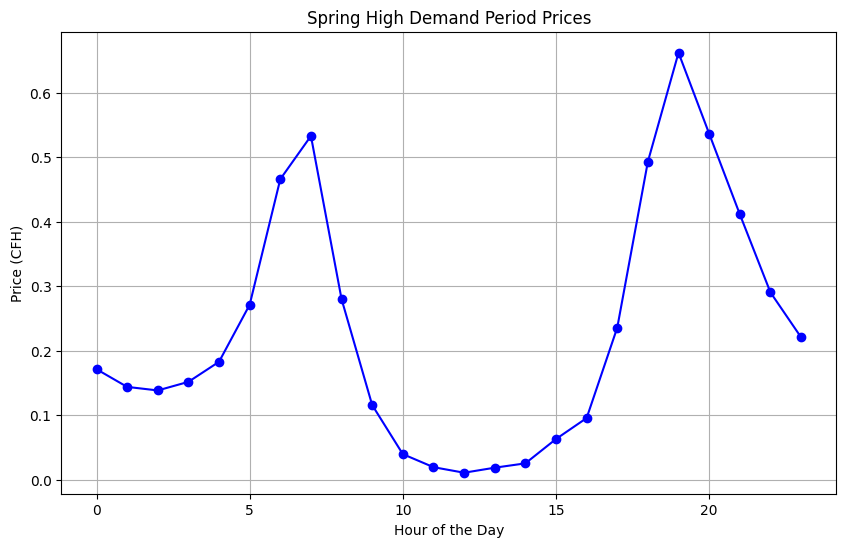

In [2]:
# Thomas prices
CFH_prices = {
    'WinterHDP': [0.1718, 0.1445, 0.0202, 0.011, 0.0331, 0.11, 0.2672, 0.3077, 0.2163, 0.1584, 
                  0.1264, 0.1047, 0.1318, 0.1835, 0.2485, 0.3123, 0.3961, 0.5254, 0.4974, 0.4525, 
                  0.3918, 0.3113, 0.1998, 0.1106], 
    'SpringHDP': [0.1714, 0.144, 0.1385, 0.1518, 0.1829, 0.2713, 0.4659, 0.5328, 0.28, 0.1158, 
                  0.0398, 0.0196, 0.011, 0.0188, 0.0255, 0.0632, 0.0957, 0.2358, 0.4931, 0.6618, 
                  0.5364, 0.4116, 0.2905, 0.2209], 
    'SummerHDP': [0.0864, 0.0587, 0.0385, 0.0246, 0.0165, 0.0215, 0.0359, 0.0206, 0.0106, 0.0192, 
                  0.0309, 0.0612, 0.0925, 0.1244, 0.1667, 0.2148, 0.3563, 0.4893, 0.7098, 0.7882, 
                  0.5586, 0.3326, 0.2152, 0.1487], 
    'FallHDP': [0.2052, 0.1284, 0.0792, 0.0531, 0.0551, 0.1193, 0.2737, 0.27, 0.0916, 0.011, 0.0389, 
                0.0238, 0.0366, 0.0611, 0.0998, 0.1888, 0.3046, 0.5198, 0.7248, 0.6936, 0.4961, 0.3569, 
                0.1822, 0.0413]
 }
# Extract the SpringHDP prices in dollar per kWh
spring_prices = CFH_prices['SpringHDP']

# Create a time vector for the 24 hours
hours = range(24)

# Plotting the prices
plt.figure(figsize=(10, 6))
plt.plot(hours, spring_prices, marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Price (CFH)')
plt.title('Spring High Demand Period Prices')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:

# Define global parameters
# Medium parameters
GCV_H2 = 
NCV_H2 = 
M_H2 =
M_O2 =
M_H2O =
cp_H2 = 
cp_O2 =
cp_air =
cp_H2O = 
Delta_H0 =

In [3]:
def optimizer(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # adapt inputs: T (horizon of simulation), ts (sampling time), SOE_battery, LOH_hess, pv, load, c_el (electricity prices)
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V0: no auxiliaries, no thermal model, no transitions, no STB state
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, P_EL, delta_ON_EL, delta_OFF_EL
    # P_batt = P_batt, ch - P_batt,disch - we assume unitary efficiency 
    
    
    # Access global parameters
    global P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_El, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, c_battery

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state
    P_batt = opti.variable(1, N)  # input
    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 
    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input

    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N

    # Solver
    opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + P_FC[t] == load[t] + P_grid_sale[t] + P_batt[t] + P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt[t]>=0)
            opti.subject_to(P_batt[t]<=0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States                
            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)


                            
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] + c_battery * ca.fabs(P_batt[t]) + (c_el[t] * P_grid_pchs[t] - 0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)

    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, P_FC_opt, obj_opt
        

In [4]:
def optimizer_V1(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V1: no auxiliaries, no thermal model, no STB state, add transitions and costs between OFF-On
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_El, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL, C_FC, c_battery
    

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state
    P_batt = opti.variable(1, N)  # input
    delta_charge = opti.variable(1,N) # binary input
    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 
    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input


    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [1]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N + [1]*N

    # Solver
    opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    opti.subject_to(delta_OFF_EL[0] == 1)
    opti.subject_to(delta_OFF_FC[0] == 1)
    

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + P_FC[t] == load[t] + P_grid_sale[t] + (P_batt[t] * delta_charge[t] - (1 - delta_charge[t]) * P_batt[t]) + P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(delta_charge[t] >= 0)
            opti.subject_to(delta_charge[t] <= 1)
            
            opti.subject_to(P_batt[t]>= 0)
            opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + (P_batt[t] * delta_charge[t] - (1 - delta_charge[t]) * P_batt[t]) * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States                
            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)
            
            # Transitions EL               
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
            opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)

            # Transitions FC               
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
            opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


            # Transitions dwwelling time for OFF-STB
            T_CLD_EL = 2 
            T_CLD_FC = 2
             # Electrolyzer constraints
            if t >= 1 and t < N - T_CLD_EL:
                opti.subject_to(sigma_OFF_ON_EL[t] - sigma_OFF_ON_EL[t-1] <= sigma_OFF_ON_EL[t+1:t + T_CLD_EL+1])
                sigma_sum_EL = sum([sigma_OFF_ON_EL[t-j] for j in range(T_CLD_EL)])
                opti.subject_to(sigma_sum_EL <= T_CLD_EL)
    
            # Fuel Cell constraints
            if t >= 1 and t < N - T_CLD_FC:
                opti.subject_to(sigma_OFF_ON_FC[t] - sigma_OFF_ON_FC[t-1] <= sigma_OFF_ON_FC[t+1:t + T_CLD_FC+1])
                sigma_sum_FC = sum([sigma_OFF_ON_FC[t-j] for j in range(T_CLD_FC)])
                opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
                    
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL * sigma_OFF_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] 
    + C_FC * sigma_OFF_ON_FC[t] + c_battery * P_batt[t] + (c_el[t] * P_grid_pchs[t] - 0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    delta_charge_opt = sol.value(delta_charge)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)

    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, sigma_OFF_ON_FC_opt, P_FC_opt, obj_opt
        

In [5]:
def optimizer_V2(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # adapt inputs: T (horizon of simulation), ts (sampling time), SOE_battery, LOH_hess, pv, load, c_el (electricity prices)
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V2: no auxiliaries, no thermal model, include STB state, and transitions and costs between OFF-On
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_El, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL_ON, C_EL_STB, C_EL_OFF, C_FC_ON, C_FC_STB, C_FC_OFF, c_battery
    

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state

    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N) # binary input

    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 

    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_STB_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_STB_FC = opti.variable(1, N)  # binary input
    sigma_STB_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_OFF_FC = opti.variable(1, N)  # binary input
    sigma_STB_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_STB_FC = opti.variable(1, N)  # binary input

    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_STB_EL = opti.variable(1, N)   # binary inpu
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_STB_EL = opti.variable(1, N)  # binary input
    sigma_STB_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_OFF_EL = opti.variable(1, N)  # binary input
    sigma_STB_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_STB_EL = opti.variable(1, N)  # binary input


    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N

    # Solver
    opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})


    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    #opti.subject_to(delta_OFF_EL[1] == 1)
    #opti.subject_to(delta_OFF_FC[1] == 1)
    

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + (P_FC[t] - P_FC_STB * delta_STB_FC[t]) 
                            == load[t] + P_grid_sale[t] + P_batt[t]  + (P_EL[t] + P_EL_STB * delta_STB_EL[t]))
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt_abs[t] >= P_batt[t])
            opti.subject_to(P_batt_abs[t] >= -P_batt[t])
            
            opti.subject_to(P_batt[t]>= - 0.9 * P_battery_nom)
            opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)                

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States                
            opti.subject_to(delta_ON_EL[t] + delta_STB_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_STB_FC[t] + delta_OFF_FC[t] == 1)
            
            # Transitions EL
            opti.subject_to(sigma_OFF_STB_EL[t] >= 0)
            opti.subject_to(sigma_OFF_STB_EL[t] <= 1)
            opti.subject_to(sigma_OFF_STB_EL[t] >= 0)
            opti.subject_to(sigma_OFF_STB_EL[t] <= 1)
            opti.subject_to(sigma_STB_OFF_EL[t] >= 0)
            opti.subject_to(sigma_STB_ON_EL[t] >= 0)
            opti.subject_to(sigma_ON_STB_EL[t] >= 0)
            opti.subject_to(sigma_ON_OFF_EL[t] >= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] >= 0)

            # OFF to STB
            opti.subject_to(sigma_OFF_STB_EL[t] - delta_OFF_EL[t-1] <= 0)
            opti.subject_to(sigma_OFF_STB_EL[t] - delta_STB_EL[t] <= 0)
            opti.subject_to(delta_OFF_EL[t-1] + delta_STB_EL[t] - sigma_OFF_STB_EL[t] <= 1)
            # STB to OFF
            opti.subject_to(sigma_STB_OFF_EL[t] - delta_STB_EL[t-1] <= 0)
            opti.subject_to(sigma_STB_OFF_EL[t] - delta_OFF_EL[t] <= 0)
            opti.subject_to(delta_STB_EL[t-1] + delta_OFF_EL[t] - sigma_STB_OFF_EL[t] <= 1)
            # STB to ON
            opti.subject_to(sigma_STB_ON_EL[t] - delta_STB_EL[t-1] <= 0)
            opti.subject_to(sigma_STB_ON_EL[t] - delta_ON_EL[t] <= 0)
            opti.subject_to(delta_STB_EL[t-1] + delta_ON_EL[t] - sigma_STB_ON_EL[t] <= 1)
            # ON to STB
            opti.subject_to(sigma_ON_STB_EL[t] - delta_ON_EL[t-1] <= 0)
            opti.subject_to(sigma_ON_STB_EL[t] - delta_STB_EL[t] <= 0)
            opti.subject_to(delta_ON_EL[t-1] + delta_STB_EL[t] - sigma_ON_STB_EL[t] <= 1)
            # ON to OFF
            opti.subject_to(sigma_ON_OFF_EL[t] - delta_ON_EL[t-1] <= 0)
            opti.subject_to(sigma_ON_OFF_EL[t] - delta_OFF_EL[t] <= 0)
            opti.subject_to(delta_ON_EL[t-1] + delta_OFF_EL[t] - sigma_ON_OFF_EL[t] <= 1)
            # OFF to ON
            opti.subject_to(sigma_OFF_ON_EL[t] == 0)               
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
            opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)


            # Transitions FC 
            opti.subject_to(sigma_OFF_STB_FC[t] >= 0)
            opti.subject_to(sigma_OFF_STB_FC[t] <= 1)
            opti.subject_to(sigma_STB_OFF_FC[t] >= 0)
            opti.subject_to(sigma_STB_ON_FC[t] >= 0)
            opti.subject_to(sigma_ON_STB_FC[t] >= 0)
            opti.subject_to(sigma_ON_OFF_FC[t] >= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] >= 0)

            # OFF to STB
            opti.subject_to(sigma_OFF_STB_FC[t] - delta_OFF_FC[t-1] <= 0)
            opti.subject_to(sigma_OFF_STB_FC[t] - delta_STB_FC[t] <= 0)
            opti.subject_to(delta_OFF_FC[t-1] + delta_STB_FC[t] - sigma_OFF_STB_FC[t] <= 1)
            # STB to OFF
            opti.subject_to(sigma_STB_OFF_FC[t] - delta_STB_FC[t-1] <= 0)
            opti.subject_to(sigma_STB_OFF_FC[t] - delta_OFF_FC[t] <= 0)
            opti.subject_to(delta_STB_FC[t-1] + delta_OFF_FC[t] - sigma_STB_OFF_FC[t] <= 1)
            # STB to ON
            opti.subject_to(sigma_STB_ON_FC[t] - delta_STB_FC[t-1] <= 0)
            opti.subject_to(sigma_STB_ON_FC[t] - delta_ON_FC[t] <= 0)
            opti.subject_to(delta_STB_FC[t-1] + delta_ON_FC[t] - sigma_STB_ON_FC[t] <= 1)
            # ON to STB
            opti.subject_to(sigma_ON_STB_FC[t] - delta_ON_FC[t-1] <= 0)
            opti.subject_to(sigma_ON_STB_FC[t] - delta_STB_FC[t] <= 0)
            opti.subject_to(delta_ON_FC[t-1] + delta_STB_FC[t] - sigma_ON_STB_FC[t] <= 1)
            # ON to OFF
            opti.subject_to(sigma_ON_OFF_FC[t] - delta_ON_FC[t-1] <= 0)
            opti.subject_to(sigma_ON_OFF_FC[t] - delta_OFF_FC[t] <= 0)
            opti.subject_to(delta_ON_FC[t-1] + delta_OFF_FC[t] - sigma_ON_OFF_FC[t] <= 1)
            # OFF to ON              
            opti.subject_to(sigma_OFF_ON_FC[t] == 0) 
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
            opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


            # Transitions dwwelling time for OFF-STB
            T_CLD_EL = 1 
            T_CLD_FC = 1
            # Electrolyzer constraints
            if t >= 1 and t < N - T_CLD_EL:
                opti.subject_to(sigma_OFF_ON_EL[t] - sigma_OFF_ON_EL[t-1] <= sigma_OFF_ON_EL[t+1:t + T_CLD_EL+1])
                sigma_sum_EL = sum([sigma_OFF_ON_EL[t-j] for j in range(T_CLD_EL)]) # should go to rage(T_CDL_EL+1)
                opti.subject_to(sigma_sum_EL <= T_CLD_EL)
    
            # Fuel Cell constraints
            if t >= 1 and t < N - T_CLD_FC:
                opti.subject_to(sigma_OFF_ON_FC[t] - sigma_OFF_ON_FC[t-1] <= sigma_OFF_ON_FC[t+1:t + T_CLD_FC+1])
                sigma_sum_FC = sum([sigma_OFF_ON_FC[t-j] for j in range(T_CLD_FC)])  # should go to rage(T_CDL_FC+1)
                opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
                    
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL_ON * sigma_OFF_STB_EL[t] + C_EL_STB * sigma_STB_OFF_EL[t] + C_EL_OFF * sigma_ON_OFF_EL[t] 
    + alpha_FC * t_s/3600 * delta_ON_FC[t] + C_FC_ON * sigma_OFF_STB_FC[t] + C_FC_STB * sigma_STB_OFF_FC[t] + C_FC_OFF * sigma_ON_OFF_FC[t] 
    + c_battery * P_batt_abs[t] + (c_el[t] * P_grid_pchs[t] - 0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)

    P_batt_opt = sol.value(P_batt)
    P_batt_abs = sol.value(P_batt_abs)

    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)

    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_STB_FC_opt = sol.value(delta_STB_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_STB_FC_opt = sol.value(sigma_OFF_STB_FC)
    sigma_STB_OFF_FC_opt = sol.value(sigma_STB_OFF_FC)
    sigma_ON_STB_FC_opt = sol.value(sigma_ON_STB_FC)
    sigma_STB_ON_FC_opt = sol.value(sigma_STB_ON_FC)
    sigma_ON_OFF_FC_opt = sol.value(sigma_ON_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)

    P_EL_opt = sol.value(P_EL)  
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_STB_EL_opt = sol.value(delta_STB_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_STB_EL_opt = sol.value(sigma_OFF_STB_EL)
    sigma_STB_OFF_EL_opt = sol.value(sigma_STB_OFF_EL)
    sigma_ON_STB_EL_opt = sol.value(sigma_ON_STB_EL)
    sigma_STB_ON_EL_opt = sol.value(sigma_STB_ON_EL)
    sigma_ON_OFF_EL_opt = sol.value(sigma_ON_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)


    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_batt_abs, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_STB_EL_opt, delta_OFF_EL_opt, sigma_OFF_STB_EL_opt, sigma_STB_OFF_EL_opt, sigma_ON_STB_EL_opt, sigma_STB_ON_EL_opt, sigma_ON_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_STB_FC_opt, delta_OFF_FC_opt, sigma_OFF_STB_FC_opt, sigma_STB_OFF_FC_opt, sigma_ON_STB_FC_opt, sigma_STB_ON_FC_opt, sigma_ON_OFF_FC_opt, sigma_OFF_ON_FC_opt , P_FC_opt, obj_opt
        

In [6]:
def optimizer_V2_gurobi(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # Adapt inputs: T (horizon of simulation), ts (sampling time), SOE_battery, LOH_hess, pv, load, c_el (electricity prices)
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V2: no auxiliaries, no thermal model, include STB state, and transitions and costs between OFF-On
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_EL, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL_ON, C_EL_STB, C_EL_OFF, C_FC_ON, C_FC_STB, C_FC_OFF, c_battery

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

 
    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state

    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N) # binary input

    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 

    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_STB_FC = opti.variable(1, N)  # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_STB_FC = opti.variable(1, N)  # binary input
    sigma_STB_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_OFF_FC = opti.variable(1, N)  # binary input
    sigma_STB_ON_FC = opti.variable(1, N)  # binary input
    sigma_ON_STB_FC = opti.variable(1, N)  # binary input

    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_STB_EL = opti.variable(1, N)  # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_STB_EL = opti.variable(1, N)  # binary input
    sigma_STB_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_OFF_EL = opti.variable(1, N)  # binary input
    sigma_STB_ON_EL = opti.variable(1, N)  # binary input
    sigma_ON_STB_EL = opti.variable(1, N)  # binary input

    # Set binary variable bounds (0 or 1)
    for var in [delta_ON_FC, delta_STB_FC, delta_OFF_FC, sigma_OFF_STB_FC, sigma_STB_OFF_FC, sigma_OFF_ON_FC, 
                sigma_ON_OFF_FC, sigma_STB_ON_FC, sigma_ON_STB_FC, delta_ON_EL, delta_STB_EL, delta_OFF_EL, 
                sigma_OFF_STB_EL, sigma_STB_OFF_EL, sigma_OFF_ON_EL, sigma_ON_OFF_EL, sigma_STB_ON_EL, sigma_ON_STB_EL]:
        opti.subject_to(var >= 0)
        opti.subject_to(var <= 1)

    # Solver
    opti.solver('gurobi', {'OutputFlag': 0})  # Set OutputFlag to 1 if you want detailed solver output

    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    opti.subject_to(delta_OFF_EL[0] == 1)
    opti.subject_to(delta_OFF_FC[0] == 1)

    # Constraints at every time step
    for t in range(N):
        # Bounds on grid
        opti.subject_to(pv[t] + P_grid_pchs[t] + (P_FC[t] - P_FC_STB * delta_STB_FC[t]) 
                        == load[t] + P_grid_sale[t] + P_batt[t]  + (P_EL[t] + P_EL_STB * delta_STB_EL[t]))
        opti.subject_to(P_grid_sale[t]>=0)
        opti.subject_to(P_grid_sale[t]<=P_grid_max)
        opti.subject_to(P_grid_pchs[t]>=0)
        opti.subject_to(P_grid_pchs[t]<=P_grid_max)

        # Bounds on battery and SOE
        opti.subject_to(P_batt_abs[t] >= P_batt[t])
        opti.subject_to(P_batt_abs[t] >= -P_batt[t])
        
        opti.subject_to(P_batt[t]>= - 0.9 * P_battery_nom)
        opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
    
        opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t] * t_s/3600)
        opti.subject_to(SOE[t] >= SOE_min)
        opti.subject_to(SOE[t] <= SOE_max)
        
        # Bounds on hydrogen storage 
        opti.subject_to(LOH[t+1] == LOH[t] + (P_EL[t] * eta_EL - P_FC[t]/eta_FC) * t_s /C_max)
        opti.subject_to(LOH[t] >= LOH_min)
        opti.subject_to(LOH[t] <= LOH_max)                

        # Constraints on electrolyzer
        # Bounds when ON                
        opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
        opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
    
        # Ramping constraints                
        if t < N-1:                
            opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
            opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                        
        # Constraints on fuel cell
        # Bounds when ON
        opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
        opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
        
        # Ramping constraints                
        if t < N-1:                
            opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
            opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                        
        # States                
        opti.subject_to(delta_ON_EL[t] + delta_STB_EL[t] + delta_OFF_EL[t] == 1)
        opti.subject_to(delta_ON_FC[t] + delta_STB_FC[t] + delta_OFF_FC[t] == 1)
        
        # Transitions EL
        opti.subject_to(sigma_OFF_STB_EL[t] >= 0)
        opti.subject_to(sigma_OFF_STB_EL[t] <= 1)
        opti.subject_to(sigma_OFF_STB_EL[t] >= 0)
        opti.subject_to(sigma_OFF_STB_EL[t] <= 1)
        opti.subject_to(sigma_STB_OFF_EL[t] >= 0)
        opti.subject_to(sigma_STB_ON_EL[t] >= 0)
        opti.subject_to(sigma_ON_STB_EL[t] >= 0)
        opti.subject_to(sigma_ON_OFF_EL[t] >= 0)
        opti.subject_to(sigma_OFF_ON_EL[t] >= 0)

        # OFF to STB
        opti.subject_to(sigma_OFF_STB_EL[t] - delta_OFF_EL[t-1] <= 0)
        opti.subject_to(sigma_OFF_STB_EL[t] - delta_STB_EL[t] <= 0)
        opti.subject_to(delta_OFF_EL[t-1] + delta_STB_EL[t] - sigma_OFF_STB_EL[t] <= 1)
        # STB to OFF
        opti.subject_to(sigma_STB_OFF_EL[t] - delta_STB_EL[t-1] <= 0)
        opti.subject_to(sigma_STB_OFF_EL[t] - delta_OFF_EL[t] <= 0)
        opti.subject_to(delta_STB_EL[t-1] + delta_OFF_EL[t] - sigma_STB_OFF_EL[t] <= 1)
        # STB to ON
        opti.subject_to(sigma_STB_ON_EL[t] - delta_STB_EL[t-1] <= 0)
        opti.subject_to(sigma_STB_ON_EL[t] - delta_ON_EL[t] <= 0)
        opti.subject_to(delta_STB_EL[t-1] + delta_ON_EL[t] - sigma_STB_ON_EL[t] <= 1)
        # ON to STB
        opti.subject_to(sigma_ON_STB_EL[t] - delta_ON_EL[t-1] <= 0)
        opti.subject_to(sigma_ON_STB_EL[t] - delta_STB_EL[t] <= 0)
        opti.subject_to(delta_ON_EL[t-1] + delta_STB_EL[t] - sigma_ON_STB_EL[t] <= 1)
        # ON to OFF
        opti.subject_to(sigma_ON_OFF_EL[t] - delta_ON_EL[t-1] <= 0)
        opti.subject_to(sigma_ON_OFF_EL[t] - delta_OFF_EL[t] <= 0)
        opti.subject_to(delta_ON_EL[t-1] + delta_OFF_EL[t] - sigma_ON_OFF_EL[t] <= 1)
        # OFF to ON
        opti.subject_to(sigma_OFF_ON_EL[t] == 0)               
        opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
        opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
        opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)


        # Transitions FC 
        opti.subject_to(sigma_OFF_STB_FC[t] >= 0)
        opti.subject_to(sigma_OFF_STB_FC[t] <= 1)
        opti.subject_to(sigma_STB_OFF_FC[t] >= 0)
        opti.subject_to(sigma_STB_ON_FC[t] >= 0)
        opti.subject_to(sigma_ON_STB_FC[t] >= 0)
        opti.subject_to(sigma_ON_OFF_FC[t] >= 0)
        opti.subject_to(sigma_OFF_ON_FC[t] >= 0)

        # OFF to STB
        opti.subject_to(sigma_OFF_STB_FC[t] - delta_OFF_FC[t-1] <= 0)
        opti.subject_to(sigma_OFF_STB_FC[t] - delta_STB_FC[t] <= 0)
        opti.subject_to(delta_OFF_FC[t-1] + delta_STB_FC[t] - sigma_OFF_STB_FC[t] <= 1)
        # STB to OFF
        opti.subject_to(sigma_STB_OFF_FC[t] - delta_STB_FC[t-1] <= 0)
        opti.subject_to(sigma_STB_OFF_FC[t] - delta_OFF_FC[t] <= 0)
        opti.subject_to(delta_STB_FC[t-1] + delta_OFF_FC[t] - sigma_STB_OFF_FC[t] <= 1)
        # STB to ON
        opti.subject_to(sigma_STB_ON_FC[t] - delta_STB_FC[t-1] <= 0)
        opti.subject_to(sigma_STB_ON_FC[t] - delta_ON_FC[t] <= 0)
        opti.subject_to(delta_STB_FC[t-1] + delta_ON_FC[t] - sigma_STB_ON_FC[t] <= 1)
        # ON to STB
        opti.subject_to(sigma_ON_STB_FC[t] - delta_ON_FC[t-1] <= 0)
        opti.subject_to(sigma_ON_STB_FC[t] - delta_STB_FC[t] <= 0)
        opti.subject_to(delta_ON_FC[t-1] + delta_STB_FC[t] - sigma_ON_STB_FC[t] <= 1)
        # ON to OFF
        opti.subject_to(sigma_ON_OFF_FC[t] - delta_ON_FC[t-1] <= 0)
        opti.subject_to(sigma_ON_OFF_FC[t] - delta_OFF_FC[t] <= 0)
        opti.subject_to(delta_ON_FC[t-1] + delta_OFF_FC[t] - sigma_ON_OFF_FC[t] <= 1)
        # OFF to ON              
        opti.subject_to(sigma_OFF_ON_FC[t] == 0) 
        opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
        opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
        opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


        # Transitions dwwelling time for OFF-STB
        T_CLD_EL = 1 
        T_CLD_FC = 1
        # Electrolyzer constraints
        if t >= 1 and t < N - T_CLD_EL:
            opti.subject_to(sigma_OFF_ON_EL[t] - sigma_OFF_ON_EL[t-1] <= sigma_OFF_ON_EL[t+1:t + T_CLD_EL+1])
            sigma_sum_EL = sum([sigma_OFF_ON_EL[t-j] for j in range(T_CLD_EL)]) # should go to rage(T_CDL_EL+1)
            opti.subject_to(sigma_sum_EL <= T_CLD_EL)
    
        # Fuel Cell constraints
        if t >= 1 and t < N - T_CLD_FC:
            opti.subject_to(sigma_OFF_ON_FC[t] - sigma_OFF_ON_FC[t-1] <= sigma_OFF_ON_FC[t+1:t + T_CLD_FC+1])
            sigma_sum_FC = sum([sigma_OFF_ON_FC[t-j] for j in range(T_CLD_FC)])  # should go to rage(T_CDL_FC+1)
            opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
                    
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL_ON * sigma_OFF_STB_EL[t] + C_EL_STB * sigma_STB_OFF_EL[t] + C_EL_OFF * sigma_ON_OFF_EL[t] 
    + alpha_FC * t_s/3600 * delta_ON_FC[t] + C_FC_ON * sigma_OFF_STB_FC[t] + C_FC_STB * sigma_STB_OFF_FC[t] + C_FC_OFF * sigma_ON_OFF_FC[t] 
    + c_battery * P_batt_abs[t] + (c_el[t] * P_grid_pchs[t] - 0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)

    P_batt_opt = sol.value(P_batt)
    P_batt_abs = sol.value(P_batt_abs)

    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)

    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_STB_FC_opt = sol.value(delta_STB_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_STB_FC_opt = sol.value(sigma_OFF_STB_FC)
    sigma_STB_OFF_FC_opt = sol.value(sigma_STB_OFF_FC)
    sigma_ON_STB_FC_opt = sol.value(sigma_ON_STB_FC)
    sigma_STB_ON_FC_opt = sol.value(sigma_STB_ON_FC)
    sigma_ON_OFF_FC_opt = sol.value(sigma_ON_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)

    P_EL_opt = sol.value(P_EL)  
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_STB_EL_opt = sol.value(delta_STB_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_STB_EL_opt = sol.value(sigma_OFF_STB_EL)
    sigma_STB_OFF_EL_opt = sol.value(sigma_STB_OFF_EL)
    sigma_ON_STB_EL_opt = sol.value(sigma_ON_STB_EL)
    sigma_STB_ON_EL_opt = sol.value(sigma_STB_ON_EL)
    sigma_ON_OFF_EL_opt = sol.value(sigma_ON_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)


    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_batt_abs, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_STB_EL_opt, delta_OFF_EL_opt, sigma_OFF_STB_EL_opt, sigma_STB_OFF_EL_opt, sigma_ON_STB_EL_opt, sigma_STB_ON_EL_opt, sigma_ON_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_STB_FC_opt, delta_OFF_FC_opt, sigma_OFF_STB_FC_opt, sigma_STB_OFF_FC_opt, sigma_ON_STB_FC_opt, sigma_STB_ON_FC_opt, sigma_ON_OFF_FC_opt, sigma_OFF_ON_FC_opt , P_FC_opt, obj_opt
        


In [7]:
def optimizer_V3(T, t_s, c_el, pv, load, SOE_initial, LOH_initial): 
    # states: SOE_battery, LOH_hess
    # inputs to FMU: P_battery, P_FC_sys (start with P_FC), P_El_sys (start with P_El), state_FC, state_EL

    # V1: no auxiliaries, no thermal model, no STB state, add transitions and costs between OFF-On, PWA efficiency
    # inputs variables in MPC: P_battery, P_grid, P_FC, delta_ON_FC, delta_OFF_FC, sigma_OFF_ON_FC, P_EL, delta_ON_EL, delta_OFF_EL, sigma_OFF_ON_EL
    
    # Access global parameters
    global M, P_grid_max, P_battery_nom, SOE_min, SOE_max
    global LOH_min, LOH_max, C_max, eta_El, eta_FC, P_EL_min, P_EL_max, P_EL_STB, P_FC_min, P_FC_max, P_FC_STB, r_EL, r_FC
    global alpha_EL, alpha_FC, C_EL, C_FC, c_battery
    

    N = int(T // t_s)
    
    # Initialize
    import casadi as ca
    opti = ca.Opti()

    # -----------------------------
    # Variables and solver
    # -----------------------------

    SOE = opti.variable(1, N+1)  # state
    LOH = opti.variable(1, N+1)  # state
    P_batt = opti.variable(1, N)  # input
    P_batt_abs = opti.variable(1,N) # input
    P_grid_sale = opti.variable(1, N)        # input 
    P_grid_pchs = opti.variable(1, N)        # input 

    P_FC = opti.variable(1, N)          # input
    delta_ON_FC = opti.variable(1, N)   # binary input
    delta_OFF_FC = opti.variable(1, N)  # binary input
    sigma_OFF_ON_FC = opti.variable(1, N)  # binary input
    x1_FC = opti.variable(1, N)   # binary input
    x2_FC = opti.variable(1, N)  # binary input
    x3_FC = opti.variable(1, N)  # binary input

    P_EL = opti.variable(1, N)          # input
    delta_ON_EL = opti.variable(1, N)   # binary input
    delta_OFF_EL = opti.variable(1, N)  # binary input
    sigma_OFF_ON_EL = opti.variable(1, N)  # binary input
    x1_EL = opti.variable(1, N)   # binary input
    x2_EL = opti.variable(1, N)  # binary input
    x3_EL = opti.variable(1, N)  # binary input

    # delta_i are discrete variables (binary)
    discrete_var = [0]*(N+1) + [0]*(N+1) + [0]*N + [0]*N + [0]*N + [0]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [0]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N + [1]*N 

    # Solver
    opti.solver('bonmin', {'discrete': discrete_var, 'bonmin.tol': 1e-4, 'bonmin.print_level': 0, 'print_time': 0})

    # -----------------------------
    # Constraints
    # -----------------------------

    
    # Initial storage level
    opti.subject_to(SOE[0] == SOE_initial)
    opti.subject_to(LOH[0] == LOH_initial)

    # Impose initial state of FC and electrolyzer to be OFF
    opti.subject_to(delta_OFF_EL[0] == 1)
    opti.subject_to(delta_OFF_FC[0] == 1)
    

    # Constraints at every time step
    for t in range(N):

            # Bounds on grid
            opti.subject_to(pv[t] + P_grid_pchs[t] + P_FC[t] == load[t] + P_grid_sale[t] + P_batt[t] + P_EL[t])
            opti.subject_to(P_grid_sale[t]>=0)
            opti.subject_to(P_grid_sale[t]<=P_grid_max)
            opti.subject_to(P_grid_pchs[t]>=0)
            opti.subject_to(P_grid_pchs[t]<=P_grid_max)

            # Bounds on battery and SOE
            opti.subject_to(P_batt_abs[t] >= P_batt[t])
            opti.subject_to(P_batt_abs[t] >= -P_batt[t])
            
            opti.subject_to(P_batt[t]>= -0.9 * P_battery_nom)
            opti.subject_to(P_batt[t]<= 0.9 * P_battery_nom)
        
            opti.subject_to(SOE[t+1] == SOE[t] + P_batt[t]  * t_s/3600)
            opti.subject_to(SOE[t] >= SOE_min)
            opti.subject_to(SOE[t] <= SOE_max)
            
            #PWA efficiency electrolyzer
            P_eta_EL = x1_EL[t] * (0.71685 * P_EL[t] + 71.8325) + x2_EL[t] * (0.56641 * P_EL[t] + 327.2039) + x3_EL[t] * (0.48142 * P_EL[t] + 616.6985)
            opti.subject_to(x1_EL[t] + x2_EL[t] + x2_EL[t] == 1)
            opti.subject_to(P_EL[t] >= 500 - M * (1-x1_EL[t]))
            opti.subject_to(P_EL[t] <= 1700 + M * (1-x1_EL[t]))
            opti.subject_to(P_EL[t] >= 1700 - M * (1-x2_EL[t]))
            opti.subject_to(P_EL[t] <= 3750 + M * (1-x2_EL[t]))
            opti.subject_to(P_EL[t] >= 3750 - M * (1-x3_EL[t]))
            opti.subject_to(P_EL[t] <= 5000 + M * (1-x3_EL[t]))

            #PWA efficiency fuel cell
            P_eta_FC = x1_FC[t] * (2.8347 * P_FC[t] - 292.4739) + x2_FC[t] * (4.0384 * P_FC[t] -2929.9436) + x3_FC[t] * (6.3259 * P_FC[t] + 11682.9301)
            opti.subject_to(x1_FC[t] + x2_FC[t] + x3_FC[t] == 1)
            opti.subject_to(P_FC[t] >= 300 - M * (1-x1_FC[t]))
            opti.subject_to(P_FC[t] <= 2200 + M * (1-x1_FC[t]))
            opti.subject_to(P_FC[t] >= 2200 - M * (1-x2_FC[t]))
            opti.subject_to(P_FC[t] <= 3800 + M * (1-x2_FC[t]))
            opti.subject_to(P_FC[t] >= 3800 - M * (1-x3_FC[t]))
            opti.subject_to(P_FC[t] <= 5000 + M * (1-x3_FC[t]))

            # Bounds on hydrogen storage 
            opti.subject_to(LOH[t+1] == LOH[t] + (P_eta_EL - P_eta_FC) * t_s /C_max)
            opti.subject_to(LOH[t] >= LOH_min)
            opti.subject_to(LOH[t] <= LOH_max)   

            # Constraints on electrolyzer
            # Bounds when ON                
            opti.subject_to(P_EL[t] >= delta_ON_EL[t] * P_EL_min)
            opti.subject_to(P_EL[t] <= delta_ON_EL[t] * P_EL_max)
        
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_EL[t+1] - P_EL[t] <= r_EL)
                opti.subject_to(P_EL[t] - P_EL[t+1] <= r_EL)
                            
            # Constraints on fuel cell
            # Bounds when ON
            opti.subject_to(P_FC[t] >= delta_ON_FC[t] * P_FC_min)
            opti.subject_to(P_FC[t] <= delta_ON_FC[t] * P_FC_max)
            
            # Ramping constraints                
            if t < N-1:                
                opti.subject_to(P_FC[t+1] - P_FC[t] <= r_FC)
                opti.subject_to(P_FC[t] - P_FC[t+1] <= r_FC)
                            
            # States                
            opti.subject_to(delta_ON_EL[t] + delta_OFF_EL[t] == 1)
            opti.subject_to(delta_ON_FC[t] + delta_OFF_FC[t] == 1)
            
            # Transitions EL               
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_OFF_EL[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_EL[t] - delta_ON_EL[t] <= 0)
            opti.subject_to(delta_OFF_EL[t-1] + delta_ON_EL[t] - sigma_OFF_ON_EL[t] <= 1)

            # Transitions FC               
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_OFF_FC[t-1] <= 0)
            opti.subject_to(sigma_OFF_ON_FC[t] - delta_ON_FC[t] <= 0)
            opti.subject_to(delta_OFF_FC[t-1] + delta_ON_FC[t] - sigma_OFF_ON_FC[t] <= 1)


            # Transitions dwwelling time for OFF-STB
            T_CLD_EL = 2 
            T_CLD_FC = 2
             # Electrolyzer constraints
            if t >= 1 and t < N - T_CLD_EL:
                opti.subject_to(sigma_OFF_ON_EL[t] - sigma_OFF_ON_EL[t-1] <= sigma_OFF_ON_EL[t+1:t + T_CLD_EL+1])
                sigma_sum_EL = sum([sigma_OFF_ON_EL[t-j] for j in range(T_CLD_EL)])
                opti.subject_to(sigma_sum_EL <= T_CLD_EL)
    
            # Fuel Cell constraints
            if t >= 1 and t < N - T_CLD_FC:
                opti.subject_to(sigma_OFF_ON_FC[t] - sigma_OFF_ON_FC[t-1] <= sigma_OFF_ON_FC[t+1:t + T_CLD_FC+1])
                sigma_sum_FC = sum([sigma_OFF_ON_FC[t-j] for j in range(T_CLD_FC)])
                opti.subject_to(sigma_sum_FC <= T_CLD_FC)
             
                    
            # Bilinear to linear


    # -----------------------------
    # Objective
    # -----------------------------

    obj = sum(alpha_EL * t_s/3600 * delta_ON_EL[t] + C_EL * sigma_OFF_ON_EL[t] + alpha_FC * t_s/3600 * delta_ON_FC[t] 
    + C_FC * sigma_OFF_ON_FC[t] + c_battery * P_batt_abs[t] + (c_el[t] * P_grid_pchs[t] - 0 * c_el[t] * P_grid_sale[t]) * t_s/3600 for t in range(N))
    opti.minimize(obj)
    
    # -----------------------------
    # Solve and get optimal values
    # -----------------------------

    sol = opti.solve()
    
    SOE_opt = sol.value(SOE)
    LOH_opt = sol.value(LOH)
    P_batt_opt = sol.value(P_batt)
    P_batt_abs_opt = sol.value(P_batt_abs)
    P_grid_sale_opt = sol.value(P_grid_sale)
    P_grid_pchs_opt = sol.value(P_grid_pchs)
    P_FC_opt = sol.value(P_FC)  
    delta_ON_FC_opt = sol.value(delta_ON_FC)
    delta_OFF_FC_opt = sol.value(delta_OFF_FC)
    sigma_OFF_ON_FC_opt = sol.value(sigma_OFF_ON_FC)
    x1_FC_opt = sol.value(x1_FC)
    x2_FC_opt = sol.value(x2_FC)
    x3_FC_opt = sol.value(x3_FC)
    P_EL_opt = sol.value(P_EL)
    delta_ON_EL_opt = sol.value(delta_ON_EL)
    delta_OFF_EL_opt = sol.value(delta_OFF_EL)
    sigma_OFF_ON_EL_opt = sol.value(sigma_OFF_ON_EL)
    x1_EL_opt = sol.value(x1_EL)
    x2_EL_opt = sol.value(x2_EL)
    x3_EL_opt = sol.value(x3_EL)


    obj_opt = round(sol.value(obj), 2)

    return SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, sigma_OFF_ON_FC_opt, P_FC_opt, obj_opt
        

In [8]:
# Define global simulation parameters
T = 3*60*60  # Time horizon length: horizon T = 3h to start
t_s = 15*60  # Time step size in seconds: ts = 15min -> for not losing too much on transitions for HESS, ideally ts should be smaller or equal to tau_CLD
N = int(T//t_s)
M = 100000

# Define global parameters
R = 8.314
F = 1.602176634 *10**(-19)
M = 5000
m = 1
V_tn = 1.482
T_amb = 273.15 + 23.5
K=1.4

# Electrolyzer parameters
eta_EL = 0.6
eta_F_EL = 0.95 # Faradaic efficiency
P_EL_STB = 285.7
P_EL_nom = 5000
P_EL_max = 5000
P_EL_min = 0.1 * P_EL_max
r_EL = 4500 # 20 W/s or depeds on t_s
C_rep_EL = 0.27*1.55*10**(-3)  # replacement cost (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_EL = 40000     # number of hours
C_OM_EL = 0.002    # O&M cost (euro/h)
alpha_EL = 1000 * (C_rep_EL * P_EL_nom /N_H_EL + C_OM_EL) # (euro/Wh * W + euro/h)
C_EL = 0.1334 #(euro)
C_EL_ON = 0.123
C_EL_STB = 0.0042 
C_EL_OFF = 0.0062 
# Electrolyzer auxiliaries parameters


# Fuel cell parameters
eta_FC = 0.4
eta_F_FC = 0.95 # Faradaic efficiency
P_FC_STB = 100
P_FC_nom = 5000
P_FC_max = 4300
P_FC_min = 300
r_FC = 5 * t_s # 5 W/s if t_s < 15min, otherwise = P_FC_max  
C_rep_FC = 0.27*1.55*10**(-3)  # replacement cost for the fuel cell (euro/W) - to be multiplied by installed power in W P_EL_nom
N_H_FC = 40000     # number of hours for the fuel cell (h)
C_OM_FC = 0.01    # O&M cost for the fuel cell (euro/h)
alpha_FC = 1000 * (C_rep_FC * P_FC_nom /N_H_FC + C_OM_FC) # (euro/Wh * W + euro/h)
C_FC = 0.018 #(euro)
C_FC_ON = 0.01 
C_FC_STB = 0.003 
C_FC_OFF = 0.005
# Fuel cell auxiliaries parameters


# Hydrogen storage parameters
LOH_min = 0.1 # (1)
LOH_max = 0.99 # (1)
C_max = 5158.1*10**6 # (J), for LHV = 119.96 MJ/kg

# Battery parameters
E_battery_nom = 5000 # (Wh)
C_battery_inv = 0.37  # investment cost for the battery (euro/Wh)
N_battery_cycles = 4000  # number of battery cycles
P_battery_nom = 5000 # (W)
c_battery = C_battery_inv * E_battery_nom / (2 * N_battery_cycles * P_battery_nom) # (euro/W)
eta_batt_ch = 0.98 # (1)
eta_batt_disch = 0.98 # (1)
SOE_min = 500 # (Wh)
SOE_max = 4500 # (Wh)

# Grid arameters
P_grid_max = 4000 # (W)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

c_el = np.random.uniform(0.05 * 10**(-3), 0.15 * 10**(-3), N )
pv = np.random.uniform(0, 10000, N)
load = np.random.uniform(3000, 10000, N )
SOE_initial = 2500  # Initial state of energy of the battery
LOH_initial = 0.5  # Initial level of hydrogen

In [10]:
# Call the optimizer function
# V0: optimizer
#SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, P_FC_opt, obj_opt = optimizer(T, t_s, c_el, pv, load, SOE_initial, LOH_initial)

# V1 and V3
SOE_opt, LOH_opt, P_batt_opt, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_OFF_FC_opt, sigma_OFF_ON_FC_opt, P_FC_opt, obj_opt = optimizer_V3(T, t_s, c_el, pv, load, SOE_initial, LOH_initial)

# V2
#SOE_opt, LOH_opt, P_batt_opt, P_batt_abs, P_grid_sale_opt, P_grid_pchs_opt, delta_ON_EL_opt, delta_STB_EL_opt, delta_OFF_EL_opt, sigma_OFF_STB_EL_opt, sigma_STB_OFF_EL_opt, sigma_ON_STB_EL_opt, sigma_STB_ON_EL_opt, sigma_ON_OFF_EL_opt, sigma_OFF_ON_EL_opt, P_EL_opt, delta_ON_FC_opt, delta_STB_FC_opt, delta_OFF_FC_opt, sigma_OFF_STB_FC_opt, sigma_STB_OFF_FC_opt, sigma_ON_STB_FC_opt, sigma_STB_ON_FC_opt, sigma_ON_OFF_FC_opt, sigma_OFF_ON_FC_opt , P_FC_opt, obj_opt = optimizer_V2(T, t_s, c_el, pv, load, SOE_initial, LOH_initial)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 0.21469156       49 0.91066
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 0.21469142       21 0.317801
NLP0014I             2         OPT 0.21469147       31 0.503916
NLP0014I             3         OPT 0.21469139       20 0.281135
NLP0014I             4         OPT 0.21469148       22 0.332977
NLP0014I             5         OPT 0.21469144       22 0.405967
NLP0014I             6        

: 

In [ ]:
# Time vector for plotting
time = np.arange(T/t_s + 1)  # Time vector with N+1 elements

plt.figure(figsize=(14, 10))

# Plot SOE
plt.subplot(3, 2, 1)
plt.plot(time[:-1], SOE_opt[:-1], marker='o')
plt.title('State of Energy (SOE) of the Battery')
plt.xlabel('Time [hours]')
plt.ylabel('SOE [Wh]')
plt.grid(True)

# Plot LOH
plt.subplot(3, 2, 2)
plt.plot(time[:-1], LOH_opt[:-1], marker='o')
plt.title('Level of Hydrogen (LOH)')
plt.xlabel('Time [hours]')
plt.ylabel('LOH [Wh]')
plt.grid(True)

# Plot P_grid
plt.subplot(3, 2, 3)
plt.plot(time[:-1], P_grid_pchs_opt, marker='o', label='Purchased from grid')
plt.plot(time[:-1], P_grid_sale_opt, marker='o', label='Sold to grid')
plt.title('Power Grid Usage')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid(True)

# Plot P_EL and P_FC
plt.subplot(3, 2, 4)
plt.plot(time[:-1], P_EL_opt, marker='o', label='P_EL')
plt.plot(time[:-1], P_FC_opt, marker='o', label='P_FC')
plt.title('Electrolyzer and Fuel Cell Power')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid(True)

# Plot all power contributions
plt.subplot(3, 2, (5, 6))
plt.plot(time[:-1], load, label='Load', marker='o')
plt.plot(time[:-1], pv, label='PV Generation', marker='o')
plt.plot(time[:-1], P_grid_sale_opt-P_grid_pchs_opt , label='Grid Power', marker='o')
plt.plot(time[:-1], P_batt_opt , label='Battery ', marker='o')
plt.plot(time[:-1], P_EL_opt, label='Electrolyzer Power (P_EL)', marker='o')
plt.plot(time[:-1], P_FC_opt, label='Fuel Cell Power (P_FC)', marker='o')
plt.title('Power Contributions')
plt.xlabel('Time [hours]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


In [ ]:
time_control = np.arange(T/t_s)  # Time vector for control signals with N elements


# Assuming time_control is defined as time[:-1] for this case

plt.figure(figsize=(14, 8))  # Larger figure size for better visibility

# Plot delta_ON_FC and delta_OFF_FC
plt.subplot(2, 2, 1)
plt.step(time_control, delta_ON_FC_opt, label='delta_ON_FC', where='mid', color='blue')
plt.step(time_control, delta_OFF_FC_opt, label='delta_OFF_FC', where='mid', color='red')
plt.step(time_control, delta_STB_FC_opt, label='delta_STB_FC', where='mid', color='green')
plt.title('Fuel Cell States')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.legend()
plt.grid(True)

# Plot delta_ON_EL and delta_OFF_EL
plt.subplot(2, 2, 2)
plt.step(time_control, delta_ON_EL_opt, label='delta_ON_EL', where='mid', color='green')
plt.step(time_control, delta_OFF_EL_opt, label='delta_OFF_EL', where='mid', color='orange')
plt.step(time_control, delta_STB_EL_opt, label='delta_STB_EL', where='mid', color='blue')
plt.title('Electrolyzer States')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.legend()
plt.grid(True)

# Plot transitions OFF-ON 
plt.subplot(2, 2, 3)
plt.step(time_control, sigma_OFF_STB_EL_opt, label='sigma_OFF_STB_EL', where='mid', color='purple')
plt.step(time_control, sigma_STB_ON_EL_opt, label='sigma_STB_ON_EL', where='mid', color='brown')
plt.title('FC and Electrolyzer Transitions')
plt.xlabel('Time [hours]')
plt.ylabel('State')
plt.legend()
plt.grid(True)

plt.tight_layout(pad=2.0)  # Adjust the layout with some padding
plt.show()

